In [12]:
import pandas as pd
import numpy as np
import requests

Edit the YourLibrary.json file to remove anything other than the tracks dict before this step

In [13]:
df_lib = pd.read_json('YourLibrary1.json')
df_lib['ID'] = df_lib['artist'] + ":" + df_lib['track']
new = df_lib["uri"].str.split(":", expand = True)
df_lib['track_uri'] = new[2]

Create the spotify dataframe

In [14]:
df0 = pd.read_json('StreamingHistory0.json')
df1 = pd.read_json('StreamingHistory1.json')
df2 = pd.read_json('StreamingHistory2.json')


df_spotify = pd.concat([df0, df1, df2])
df_spotify['ID'] = df_spotify['artistName'] + ":" + df_spotify['trackName']
df_spotify['In Library'] = np.where(df_spotify['ID'].isin(df_lib['ID'].tolist()),1,0)
df_spotify = pd.merge(df_spotify, df_lib[['album','ID']],how='left',on=['ID'])

Get the Client_ID and Client_secret from here https://developer.spotify.com/dashboard. Sign in and create a new app then you'll find the Client_ID and Client_secret.

In [15]:
# Abdul's:
# '627f31b5a8d740d588a087cc4b12241b'
# 'e6021b4f149249f5bea550510114b907'
# benji's:
# '8e754f00224149dd9a0e25e13691ad7a'
# '0764f9bdf8cc449abd99de83c10ffd79'

Client_ID = '8e754f00224149dd9a0e25e13691ad7a'
Client_secret = '0764f9bdf8cc449abd99de83c10ffd79'

Request authorization from spotify and get the access token

In [16]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': Client_ID,
    'client_secret': Client_secret,
})
auth_response_data = auth_response.json()
access_token = auth_response_data['access_token']

Get the genres from spotify using the uri

In [ ]:
headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}
BASE_URL = 'https://api.spotify.com/v1/'

dict_genre = {}
track_uris = df_lib['track_uri'].to_list()
for t_uri in track_uris:
    
    dict_genre[t_uri] = {'artist_uri': "", "genres":[]}
    
    r = requests.get(BASE_URL + 'tracks/' + t_uri, headers=headers)
    r = r.json()
    a_uri = r['artists'][0]['uri'].split(':')[2]
    dict_genre[t_uri]['artist_uri'] = a_uri
    
    s = requests.get(BASE_URL + 'artists/' + a_uri, headers=headers)
    s = s.json()
    dict_genre[t_uri]['genres'] = s['genres']

Put the genres in a dataframe

In [16]:
df_genre = pd.DataFrame.from_dict(dict_genre, orient='index')
df_genre.insert(0, 'track_uri', df_genre.index)
df_genre.reset_index(inplace=True, drop=True)
df_genre = df_genre.explode('genres')
df_genre

,track_uri,artist_uri,genres
0,3dyI5HVTPyxC5OWwz7ypvb,4U2ShivcI1JrdqWeyACzAq,panamanian pop
1,67GuJrAVnnEUf9P9tOip2H,2DspEsT7UXGKd2VaaedgG4,latin
1,67GuJrAVnnEUf9P9tOip2H,2DspEsT7UXGKd2VaaedgG4,reggaeton
1,67GuJrAVnnEUf9P9tOip2H,2DspEsT7UXGKd2VaaedgG4,reggaeton flow
1,67GuJrAVnnEUf9P9tOip2H,2DspEsT7UXGKd2VaaedgG4,trap latino
...,...,...,...
907,1OeyTOzeEZUOPVbyaGaabb,5H1nN1SzW0qNeUEZvuXjAj,reggaeton
907,1OeyTOzeEZUOPVbyaGaabb,5H1nN1SzW0qNeUEZvuXjAj,trap latino
908,2sA4woGW5KgEgGXXxOKPAZ,2pQAUIesBqfT87PaM1ijtk,reggaeton
908,2sA4woGW5KgEgGXXxOKPAZ,2pQAUIesBqfT87PaM1ijtk,reggaeton flow


Create a wordcloud of the genres

In [17]:
from pathlib import Path
import wordcloud as wc
import matplotlib.pyplot as plt

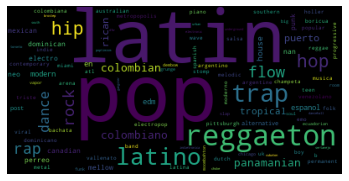

In [28]:
df_genre['genres']=df_genre['genres'].astype(str)
genres = ' '.join(df_genre['genres'].tolist())
cloud = wc.WordCloud(collocations=False)
genre_cloud = cloud.generate(genres)
plt.axis('off')
plt.imshow(genre_cloud)